# Introduction
This jupyter notebook covers part of the project related to:

1) Data acquisition (Kaggle competition using Kaggle API)
2) Data type optimization for memory usage reduction and preparing data to run automated feature engineering
3) Feature enginering (using automated feature engineering framework OpenFE)
4) Creation of machine learning model using Autogluon (AutoML framework) and experimentation tracking using MlFlow
5) Getting the model from s3 bucket using MlflowClient
5) Predicting on the test set and submiting results to Kaggle competition 

The part with model deployment as web-service and monitoring will be covered in the folder web_service_mlflow_visualization.

### Table of Contents
- [Importing Libraries](#importing-libraries)
- [Connecting to Kaggle Competition and Downloading Data](#connecting-to-kaggle-competition-and-downloading-data)
- [Data Preprocessing](#data-preprocessing)
- [Automated Feature Engineering using OpenFE](#automated-feature-engineering-using-openfe)
- [Model Building using AutoGluon and Tracking using MLflow Server](#model-building-using-autogluon-and-tracking-using-mlflow-server)
- [Submitting Results to Kaggle Competition and Storing Results in MLflow](#submitting-results-to-kaggle-competition-and-storing-results-in-mlflow)


#### Importing Libraries

You can notice below that most of the code is wrapped in custom modules. 
1) kaggle_client - is a kaggle API wrapper that allows to download test, train, and submition files. It also provides a convinient way to submit results to kaggle competetion.
2) data_preprocesing - is used for data type optimization and preparing data for automated feature enginerring framework OpenFE.
3) feature_engineering - is a wrapper around OpenFE, where it creates stratified sample and uses it to create new features from existing ones. More detail look in [feature_engineering.ipynb](https://github.com/ArturGR3/MLOPs-homeworks/blob/main/project/mlops_project/feature_engineering/feature_engineering.ipynb)
4) mlflow_client - is a wrapper around Autogluon (AutoML framework) and Mlflow experiment tracking.
5) download_folder_s3 - is used to pull folder from S3 bucket. We will need this to bring in AutoGluon model back from S3 for predictions.

In [2]:
import pandas as pd
import os
import sys
import json
from mlflow.tracking import MlflowClient
from autogluon.tabular import TabularPredictor
import logging
from dotenv import load_dotenv, find_dotenv

# Make sure that correct .env is loaded
load_dotenv(find_dotenv(filename="mlops_project.env", usecwd=True, raise_error_if_not_found=True))
project_path = os.getenv("PROJECT_PATH")
print(f"project path {project_path}")

# Make sure that the project path is in the sys.path to be able to import modules
if project_path not in sys.path:
    sys.path.append(project_path)

# Import custom modules
from modules.kaggle_client import KaggleClient 
from modules.data_preprocesing import DataPreprocessor 
from modules.feature_engineering import FeatureEnginering 
from modules.mlflow_client import MLflowAutoGluon 
from modules.download_folder_s3 import download_s3_folder, list_files_in_s3_folder 

/opt/conda/envs/project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


project path /workspaces/MLOPs-homeworks/project/mlops_project


#### Connecting to Kaggle Competition and Downloading Data

We are using one of the tabular playground searies [Regression with a Tabular Media Campaign Cost Dataset](https://www.kaggle.com/competitions/playground-series-s3e11/overview) that aim to predict the cost of media campaign. This analysis could be easily replicated to other tabular series by changing below parameters.

In [3]:
# Define the competition name and target column
competition_name = "playground-series-s3e11"
autogluon_preset = ['best_quality']
run_time = 4 # in minutes
target = "cost"

In [4]:
# Initialize KaggleClient to be able to talk to kaggle API
kaggle_client = KaggleClient(competition_name=competition_name, target_column=target)
# Downloads raw data for a given competition locally to the data folder
kaggle_client.download_data()
# Show the content of the data folder
os.listdir(f"{project_path}/data/{competition_name}/raw")

Data downloaded /workspaces/MLOPs-homeworks/project/mlops_project/data/playground-series-s3e11/raw


['train.csv', 'test.csv', 'sample_submission.csv']

#### Data Preprocessing
Here were will perform some data types optimization techniques to reduce the storage size and efficiency of the models that we are building. Some of the optimization techniques include:
1) Downcasting numeric columns to reduce memory usage.
2) Converting object columns to category or datetime columns based on uniqueness.
3) Converting float columns to integer columns if all fractional parts are 0.
4) Replacing some of the special characters in column names to '_' to be able to feed the dataset to OpenFe.

All the data type changes and column name transformations will be stored in convinient json file.

In [5]:
# Preprocess data to adjust data types and reduce memory usage
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")

data_preprocessor = DataPreprocessor(competition_name)
train = pd.read_csv(os.path.join(data_preprocessor.df_raw_path, "train.csv"))
test = pd.read_csv(os.path.join(data_preprocessor.df_raw_path, "test.csv"))
submission = pd.read_csv(os.path.join(data_preprocessor.df_raw_path, "sample_submission.csv"))

In [6]:
# Sample data before preprocessing
train.head(5).T

,0,1,2,3,4
id,0.00,1.00,2.00,3.00,4.00
store_sales(in millions),8.61,5.00,14.08,4.02,2.13
unit_sales(in millions),3.00,2.00,4.00,3.00,3.00
total_children,2.00,4.00,0.00,5.00,5.00
num_children_at_home,2.00,0.00,0.00,0.00,0.00
avg_cars_at home(approx).1,2.00,3.00,3.00,0.00,3.00
gross_weight,10.30,6.66,21.30,14.80,17.00
recyclable_package,1.00,1.00,1.00,0.00,1.00
low_fat,0.00,0.00,0.00,1.00,1.00
units_per_case,32.00,1.00,26.00,36.00,20.00


Based on the logging below, you can notice that storage memory reduced by around 78% which is pretty significant, given that we did not loose much information in converting these columns to more optimal data types.

In [7]:
# Preprocessing data
train = data_preprocessor.optimize_dtypes(train)
test = data_preprocessor.optimize_dtypes(test)

2024-07-23 14:22:11,606 - modules.data_preprocesing - INFO - Initial memory usage: 0.045640 GB


2024-07-23 14:22:11,722 - modules.data_preprocesing - INFO - Final memory usage: 0.010739 GB
2024-07-23 14:22:11,723 - modules.data_preprocesing - INFO - Memory reduced by 0.034901 GB (76.47%).
2024-07-23 14:22:11,753 - modules.data_preprocesing - INFO - Data stored in /workspaces/MLOPs-homeworks/project/mlops_project/data/playground-series-s3e11/preprocessed/data_dtype_optimized.pkl
2024-07-23 14:22:11,757 - modules.data_preprocesing - INFO - JSON data saved to /workspaces/MLOPs-homeworks/project/mlops_project/data/playground-series-s3e11/preprocessed/column_changes.json
2024-07-23 14:22:11,758 - modules.data_preprocesing - INFO - JSON data saved to /workspaces/MLOPs-homeworks/project/mlops_project/data/playground-series-s3e11/preprocessed/dtype_changes.json
2024-07-23 14:22:11,761 - modules.data_preprocesing - INFO - Initial memory usage: 0.028637 GB
2024-07-23 14:22:11,832 - modules.data_preprocesing - INFO - Final memory usage: 0.006264 GB
2024-07-23 14:22:11,833 - modules.data_pre

You can see the mapping of old column names to new columns from json file that we stored after preprocessing.

In [8]:
# Renaming columns
with open("/workspaces/MLOPs-homeworks/project/mlops_project/data/playground-series-s3e11/preprocessed/column_changes.json", "r") as f:
    column_changes = json.load(f)
column_changes = pd.Series(column_changes)
column_changes

id                                                    id
store_sales(in millions)        store_sales_in_millions_
unit_sales(in millions)          unit_sales_in_millions_
total_children                            total_children
num_children_at_home                num_children_at_home
avg_cars_at home(approx).1    avg_cars_at_home_approx__1
gross_weight                                gross_weight
recyclable_package                    recyclable_package
low_fat                                          low_fat
units_per_case                            units_per_case
store_sqft                                    store_sqft
coffee_bar                                    coffee_bar
video_store                                  video_store
salad_bar                                      salad_bar
prepared_food                              prepared_food
florist                                          florist
dtype: object

Below you can see what were the data types changes, you can notice that some of the heavy float64 data types moved to int8, that significantly reduced that memory usage.

In [9]:
# Optimizing data types
with open("/workspaces/MLOPs-homeworks/project/mlops_project/data/playground-series-s3e11/preprocessed/dtype_changes.json", "r") as f:
    dtype_changes = json.load(f)
df_dtype_changes = pd.DataFrame(dtype_changes)
df_dtype_changes.T

,old_dtype,new_dtype
low_fat,float64,int8
store_sqft,float64,int32
total_children,float64,int8
recyclable_package,float64,int8
salad_bar,float64,int8
avg_cars_at_home_approx__1,float64,int8
unit_sales_in_millions_,float64,int8
florist,float64,int8
units_per_case,float64,int8
gross_weight,float64,float32


#### Automated Feature Engineering using OpenFE library
We use open source package [OpenFE](https://github.com/IIIS-Li-Group/OpenFE) for automated feature engineering. It takes time to run this process on relatevilly large datasets, thus we perform stratified sampling to be able to create features faster. More in depth analysis about this technique and effect of new features on model performance you can find it this [Medium article](paste a link).

In [10]:
# Feature engineering with OpenFE
feature_engineering = FeatureEnginering(competition_name, target_column="cost")
train_transformed, test_transformend = feature_engineering.openfe_transform(train, test)

# Saving transformed data
train_transformed = pd.read_pickle(
    filepath_or_buffer=f"{project_path}/data/{competition_name}/feature_engineered/train_transformed.pkl"
)
test_transformed = pd.read_pickle(
    filepath_or_buffer=f"{project_path}/data/{competition_name}/feature_engineered/test_transformed.pkl"
)


100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


The top 5 generated features are:
GroupByThenMean(video_store,store_sqft)
Combine(store_sqft,salad_bar)
(store_sqft/florist)
CombineThenFreq(total_children,store_sqft)
(avg_cars_at_home_approx__1/store_sqft)


#### Model Building using AutoGluon and Tracking using MLflow Server
For model building, we will use the AutoML library AutoGluon, which provides an easy way to create an ensemble of models with hyperparameter tuning in a few lines of code. We will use an MLflow server on EC2 with an S3 bucket as the artifact store to keep track of model performance. AutoGluon offers a way to store the model specifically for deployment, reducing the memory requirements. This model will be used for deployment as a web service in the second part of the project.

In [17]:
# Create autogloun model using MlfLow server in EC2 and store artifacts in S3
# You need to make sure that EC2 instance is running the server
tracking_server = os.getenv("TRACKING_SERVER_HOST")
artifact_path_s3 = os.getenv("AWS_BUCKET_NAME")
experiment_name = "mlops_project"

In [21]:

mlflow_autogluon_remote_aws_ec2 = MLflowAutoGluon(
    tracking_server="remote",
    backend_store=tracking_server,
    artifact_location=f"s3://{artifact_path_s3}",
    experiment_name=experiment_name,
    competition_name=competition_name,
    target_name=target,
)
mlflow_autogluon_remote_aws_ec2.train_and_log_model(
    presets=autogluon_preset,
    target=target,
    train_transformed=train_transformed,
    test_transformed=test_transformed,
    run_time=4,
)

Remote setup with remote tracking server


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.19
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #23~22.04.1-Ubuntu SMP Thu May  9 17:59:24 UTC 2024
CPU Count:          2
Memory Avail:       4.52 GB / 7.74 GB (58.4%)
Disk Space Avail:   8.45 GB / 31.33 GB (27.0%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)


No process to kill on port 5000
Experiment mlops_project already exists
Experiment Name: mlops_project
Experiment ID: 3
Artifact Location: s3://mlflow-artifact-ag3
Creation timestamp: 1721744852421
Current tracking URI: http://ec2-13-60-23-26.eu-north-1.compute.amazonaws.com:5000


Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 60s of the 240s of remaining time (25%).
		Context path: "AutoGluon_mlflow_best_quality/ds_sub_fit/sub_fit_ho"
Running DyStack sub-fit ...
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutoGluon_mlflow_best_quality/ds_sub_fit/sub_fit_ho"
Train Data Rows:    320298
Train Data Columns: 21
Label Column:       cost
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memo

#### Submitting Results to Kaggle Competition and Storing Results in MLflow
We will use our model to create predictiong for Kaggle competition and use Kaggle API to submit our results. For that we will use MlflowClient to get the experiment name, experiment id and run_id. We will need this information to download the model from s3 bucket locally to perform prediction on test set.

In [23]:
# Lets pull the model from s3 bucket where we stored it 
# For that we need to get the empexperiment id and run id using MflfowClient
mlflow_client = MlflowClient(f'http://{tracking_server}:5000')
experiment = mlflow_client.get_experiment_by_name(experiment_name)

print("---")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Name: {experiment.name}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Lifecycle Stage: {experiment.lifecycle_stage}")
print("---")

---
Experiment ID: 3
Name: mlops_project
Artifact Location: s3://mlflow-artifact-ag3
Lifecycle Stage: active
---


In [24]:
run_name = autogluon_preset[0]

# Search for runs with the specified run name
runs = mlflow_client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{run_name}'"
)

experiment_id = experiment.experiment_id
if runs:
    run_id = runs[0].info.run_id
    print(f"Experiment ID: {experiment.experiment_id}, Run ID: {run_id}")
else:
    print("No run found with the specified name.")
    

Experiment ID: 3, Run ID: 62f1decc0ef14c0a80d3aef1e1643018


I created a convinient function list_files_in_s3_folder to list the contents of the s3 folder where we stored our model.

In [27]:
s3_folder = f"{run_id}/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/"
list_files_in_s3_folder(bucket_name=artifact_path_s3, s3_folder=s3_folder)

62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/learner.pkl
62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/metadata.json
62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/models/LightGBMXT_BAG_L1_FULL/S1F1/model.pkl
62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/models/LightGBMXT_BAG_L1_FULL/model.pkl
62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/models/LightGBMXT_BAG_L2_FULL/S1F1/model.pkl
62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/models/LightGBMXT_BAG_L2_FULL/mode

Based on my research you can pull files one at a time from s3 bucket, but there is not straight way to bring in the folder with all its contents. I build the function download_s3_folder that does that. Below we store our model locally to further use it for predicting on the test set and deploy it as web service.

In [28]:
download_s3_folder(bucket_name=artifact_path_s3, 
                   s3_folder=s3_folder, 
                   local_dir=f"{project_path}/model/{competition_name}")

Downloaded 62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/learner.pkl to /workspaces/MLOPs-homeworks/project/mlops_project/model/playground-series-s3e11/learner.pkl
Downloaded 62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/metadata.json to /workspaces/MLOPs-homeworks/project/mlops_project/model/playground-series-s3e11/metadata.json
Downloaded 62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/models/LightGBMXT_BAG_L1_FULL/S1F1/model.pkl to /workspaces/MLOPs-homeworks/project/mlops_project/model/playground-series-s3e11/models/LightGBMXT_BAG_L1_FULL/S1F1/model.pkl
Downloaded 62f1decc0ef14c0a80d3aef1e1643018/artifacts/AutoGluon_mlflow_best_quality_deployment/artifacts/AutoGluon_mlflow_best_quality_deployment/models/LightGBMXT_BAG_L1_

Autogluon provides a convinient way to load the model using TabularPredictor.load method, we use it to bring in model and create predictions for the test set. We store results as csv file to further submit it to Kaggle competetion.

In [29]:
# Load the model for predictions 
predictor = TabularPredictor.load(f"{project_path}/model/{competition_name}")
# Create a folder for submitions 
submission_path = f"data/{competition_name}/submission_files"
os.makedirs(submission_path, exist_ok=True)
# Make predictions
submission[target] = predictor.predict(test_transformed)
submission_file = f"{submission_path}/sub_{run_time}_{autogluon_preset}.csv"
submission.to_csv(submission_file, index=False)

We use our kaggle client to submit the results to the competition and get the score back.

In [31]:
# Submit the file to Kaggle
kaggle_score = kaggle_client.submit(
    submission_file=submission_file,
    model_name=autogluon_preset,
    message=f"AutoGluon {autogluon_preset} {run_time} min",
)

100%|██████████| 3.81M/3.81M [00:01<00:00, 3.58MB/s]


Submission data/playground-series-s3e11/submission_files/sub_4_['best_quality'].csv for playground-series-s3e11 using ['best_quality']: 'AutoGluon ['best_quality'] 4 min'
Submission score: 0.2987


Below we store kaggle score in Mlflow for our experiment. 

In [32]:
# Log the new metric to the existing run
metric_name = "kaggle_score"
metric_value = kaggle_score

# Log the kaggle score
mlflow_client.log_metric(run_id, metric_name, metric_value)

In the screenshot below you can see, the results from AutoGluon model run with kaggle score. 

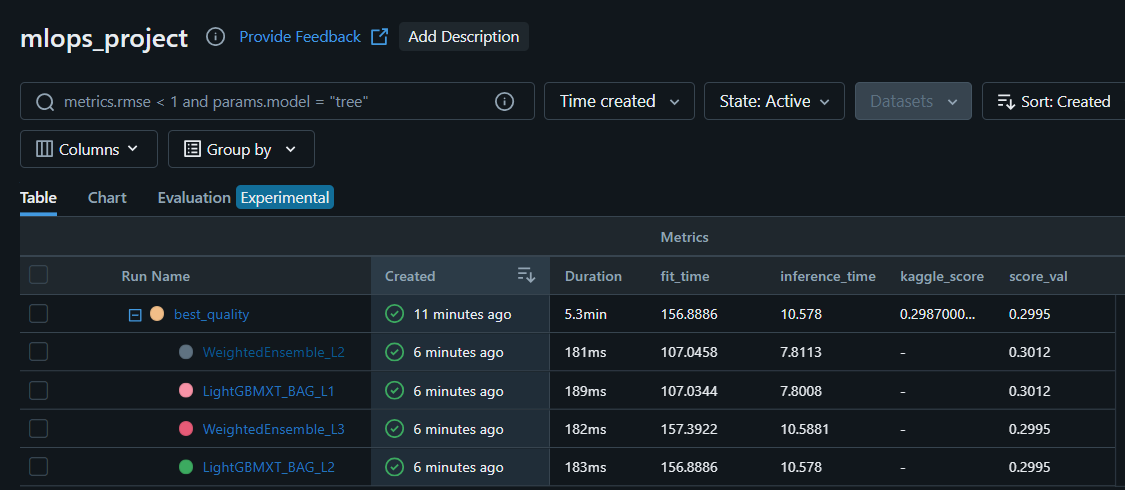

In [35]:
from PIL import Image
from IPython.display import display
image = Image.open(f"{project_path}/MlfLow_summary.png")
display(image)

Within MlflowAutogluon class I have implemented 2 other options to track experiments: 
1) No tracking server, with local backend and artifact store
2) With local tracking server, with sqlite backend store and local filesystem for artifacts.

For the sake of simplicity I left them here commented, but user can try them on if needed.

In [ ]:
# Scenario 2:
## Tracking server: no
## Backend store: local filesystem
## Artifacts store: local filesystem

## --------------------
# mlflow_autogluon_local = MLflowAutoGluon(
#     tracking_server="no",
#     backend_store=f"{project_path}/mlruns",
#     artifact_location=f"{project_path}/mlruns",
#     experiment_name="test",
#     competition_name=competition_name,
#     target_name=target,
# )
# mlflow_autogluon_local.train_and_log_model(
#     presets=["medium_quality"],
#     target=target,
#     train_transformed=train_transformed,
#     test_transformed=test_transformed,
#     run_time=1,
#     for_deployment=True,
#     for_kaggle_submission=False,
# )
## --------------------

In [ ]:
# Scenario 3:
## tracking server: yes, local server
## backend store: sqlite database
## artifacts store: local filesystem

## --------------------
# mlflow_autogluon_local_server = MLflowAutoGluon(
#     tracking_server="local",
#     backend_store=f"{project_path}/backend.db",
#     artifact_location=f"{project_path}/mlruns",
#     experiment_name="test_32",
#     competition_name=competition_name,
#     target_name=target,
# )
# mlflow_autogluon_local_server.train_and_log_model(
#     presets=["best_quality"],
#     target=target,
#     train_transformed=train_transformed,
#     test_transformed=test_transformed,
#     run_time=1,
# )
## --------------------

#### Conclusion and Next steps

Things to add: 
1) automatic pull of experiment name, id, run_id, without manually adding them. 
2) add screenshots from the Mlflow with kaggle score and supporting models.

The first part of the project that covers parts from getting the data and building the model for deployment